# THE FORK

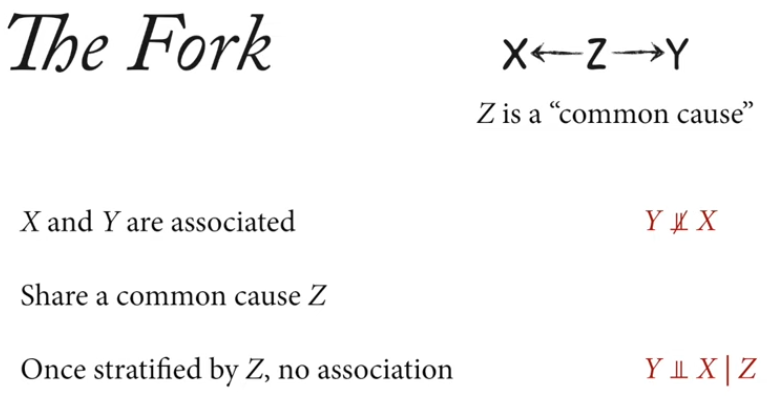

In [1]:
import numpy as np 
import pandas as pd 

# bernoulli just special case of binomial where... 


n = 1000
# Simulate Z which means sample from it 
Z = np.random.binomial(1, 0.5, size=n)

# Create X and Y as dependents of Z 
X = np.random.binomial(1, (1-Z)*0.1 + Z*0.9, size=n)
Y = np.random.binomial(1, (1-Z)*0.1 + Z*0.9, size=n)



d = [((X == i) & (Y == j)).sum() for i in range(2) for j in range(2)]
d = pd.DataFrame(data=[[d[0],d[1]], [d[2],d[3]]])
d

,0,1
0,388,101
1,89,422


In [2]:
def perasons_correlation(x,y):
    xm = np.mean(x)
    ym = np.mean(y)
    numerator = ((x - xm)*(y - ym)).sum()
    denom = np.sqrt(np.sum((x - xm)**2) * np.sum((y - ym)**2))
    return numerator / denom

perasons_correlation(X,Y)

0.6197939387357474

So X and Y are highly correlated (obviously due to both being GENERATED conditional on Z)

But condition on Z removes this.... e.g. for Z samples = 0 / 1

In [3]:
perasons_correlation(X[Z == 0],Y[Z == 0])

-0.036435953004260425

In [4]:
perasons_correlation(X[Z == 1],Y[Z == 1])

-0.08992565384706419

Boom. No correaltion affter CONDITOINIGN 

## Continuous version 

In [5]:
import matplotlib.pyplot as plt 
import seaborn as sns 

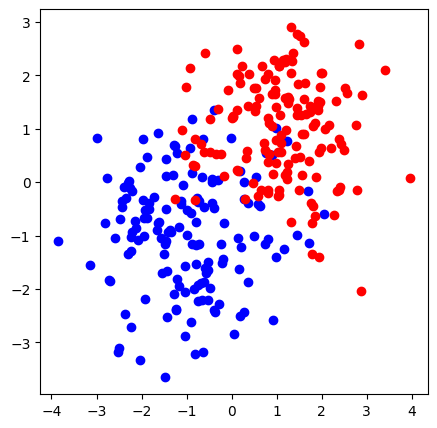

In [6]:
n = 300
Z = Z = np.random.binomial(1, 0.5, size=n)
X = np.random.normal(loc=2*Z-1, scale=1, size=n)
Y = np.random.normal(loc=2*Z-1, scale=1, size=n)

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.scatter(X[Z==0], Y[Z==0], color="blue")
axs.scatter(X[Z==1], Y[Z==1], color="red")
#axs.axhline(y=0.5, color='r', linestyle='-')

In [7]:
import pymc as pm

from pymc import HalfCauchy, Model, Normal, sample


with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy("sigma", beta=10)
    intercept = Normal("Intercept", 0, sigma=20)
    slope = Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = Normal("y", mu=intercept + slope * X, sigma=sigma, observed=Y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.


In [8]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [9]:
data = pd.DataFrame(dict(x=X, y=Y))
data

,x,y
0,-2.473804,-0.680535
1,0.552327,1.433863
2,-1.970429,0.807994
3,-1.084023,-0.059788
4,1.996965,0.642548
...,...,...
295,1.154615,2.282426
296,2.347175,-0.167232
297,-0.844851,-1.994363
298,2.382326,0.815011


In [10]:
import bambi as bmb
model = bmb.Model("y ~ x", data)
idata = model.fit(draws=2999)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 2_999 draw iterations (4_000 + 11_996 draws total) took 3 seconds.


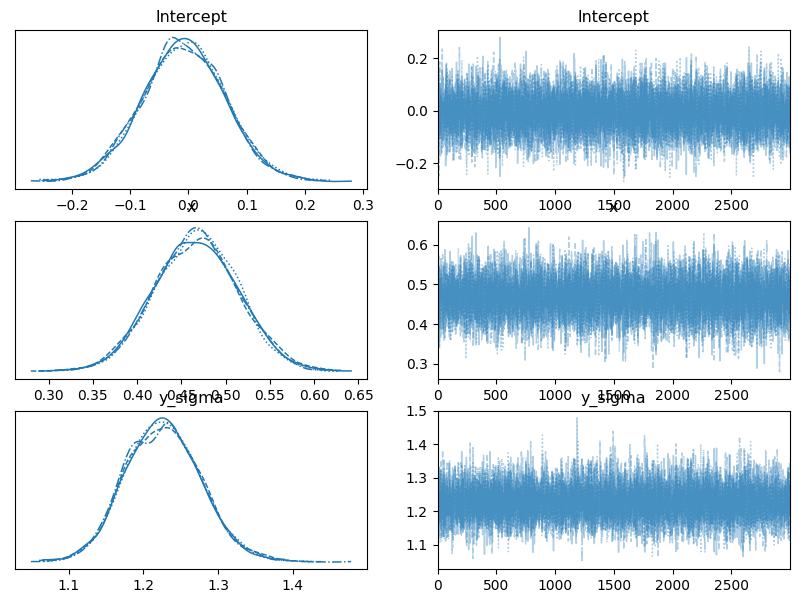

In [11]:
import arviz as az
az.plot_trace(idata, figsize=(10, 7));

In [12]:
import xarray as xr
idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["x"] * xr.DataArray(X)

In [13]:
idata.posterior["x"].shape, idata.posterior["Intercept"].shape, xr.DataArray(X).shape

((4, 2999), (4, 2999), (300,))

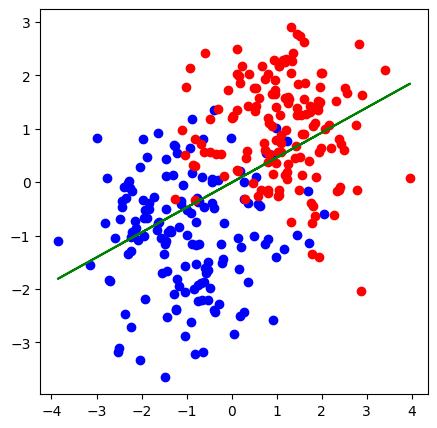

In [14]:

    
fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.scatter(X[Z==0], Y[Z==0], color="blue")
axs.scatter(X[Z==1], Y[Z==1], color="red")
# claculate mean y prediction over 4 chains, 3k samples
idata.posterior["y_model"] = (
    idata.posterior["Intercept"] + 
    idata.posterior["x"] * xr.DataArray(X)
)
mean_pred_y_all = np.mean(idata.posterior["y_model"], axis=(0,1)) 
axs.plot(X, mean_pred_y_all, color='green')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 3 seconds.


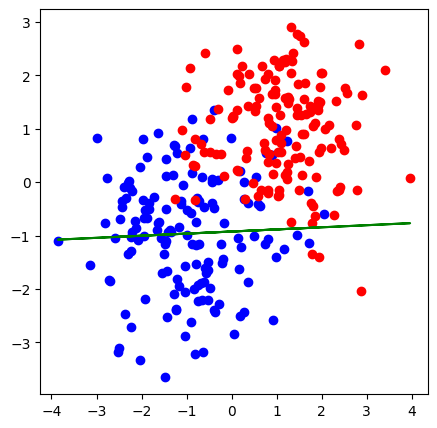

In [15]:
data = pd.DataFrame(dict(x=X[Z==0], y=Y[Z==0]))
model = bmb.Model("y ~ x", data)
idata = model.fit(draws=3000)
idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["x"] * xr.DataArray(X)

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.scatter(X[Z==0], Y[Z==0], color="blue")
axs.scatter(X[Z==1], Y[Z==1], color="red")
# claculate mean y prediction over 4 chains, 3k samples
idata.posterior["y_model"] = (
    idata.posterior["Intercept"] + 
    idata.posterior["x"] * xr.DataArray(X)
)
mean_pred_y_0 = np.mean(idata.posterior["y_model"], axis=(0,1)) 
axs.plot(X, mean_pred_y_0, color='green')



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 3 seconds.


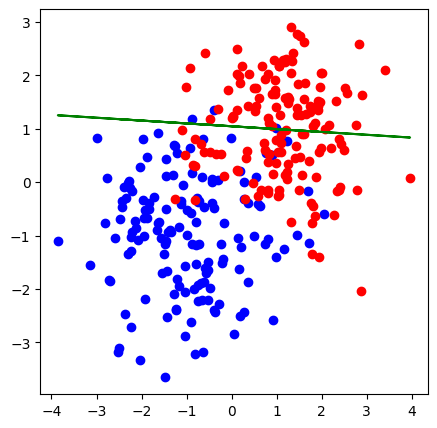

In [16]:
data = pd.DataFrame(dict(x=X[Z==1], y=Y[Z==1]))
model = bmb.Model("y ~ x", data)
idata = model.fit(draws=3000)
idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["x"] * xr.DataArray(X)

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.scatter(X[Z==0], Y[Z==0], color="blue")
axs.scatter(X[Z==1], Y[Z==1], color="red")
# claculate mean y prediction over 4 chains, 3k samples
idata.posterior["y_model"] = (
    idata.posterior["Intercept"] + 
    idata.posterior["x"] * xr.DataArray(X)
)
mean_pred_y_1 = np.mean(idata.posterior["y_model"], axis=(0,1)) 
axs.plot(X, mean_pred_y_1, color='green')



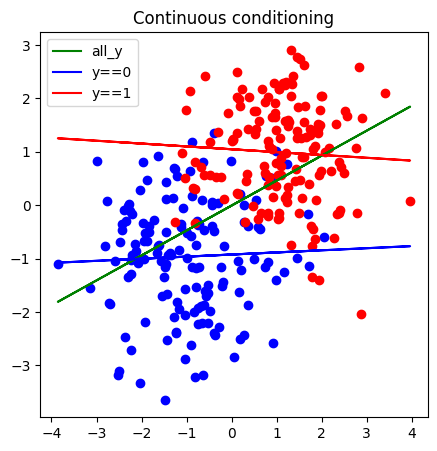

In [21]:
fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.scatter(X[Z==0], Y[Z==0], color="blue")
axs.scatter(X[Z==1], Y[Z==1], color="red")
axs.plot(X, mean_pred_y_all, color='green', label='all_y')
axs.plot(X, mean_pred_y_0, color='blue', label='y==0')
axs.plot(X, mean_pred_y_1, color='red', label='y==1')
plt.title('Continuous conditioning')
plt.legend()